In [1]:
%matplotlib inline

In [2]:
import logging

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.metrics import f1_score

In [6]:
import matplotlib.pyplot as plt

In [7]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

# Load dataset

In [8]:
mode = PathologicalImagesDatasetMode.Val
nb_folds = 5
fold_number = 0
base_dir = config.DATASET_TRAIN_DIR

In [9]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 0 - 34 images


In [10]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [11]:
images = np.stack(images)
masks = np.stack(masks)

In [12]:
images.shape, masks.shape

((34, 500, 500, 3), (34, 500, 500))

# Load predictions 

In [13]:
models = ['unet', ]
patch_size_train = 0
patch_size_predict = 0
use_dice=False

In [53]:
predictions = []
for model in models:
    filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice)
    _, model_predictions = load_pickle(filename)
    
    predictions.append(model_predictions)

In [54]:
[p.shape for p in predictions]

[(34, 500, 500)]

In [55]:
predictions_masks = []
for model_predictions in predictions:
    model_predictions_mask = np.zeros_like(model_predictions)
    model_predictions_mask[model_predictions>0.4] = 1
    
    predictions_masks.append(model_predictions_mask)

# Plot predictions

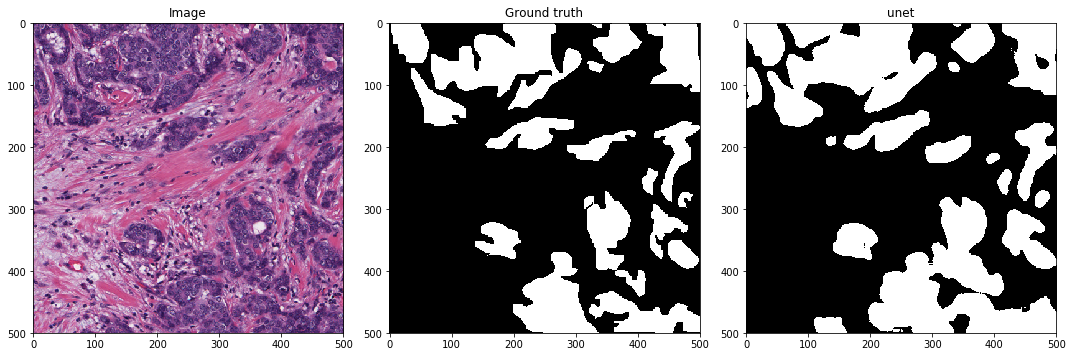

In [56]:
i = 4

fig, (ax_image, ax_groud_truth, *ax_models) = plt.subplots(1, 2 + len(models), figsize=(5 * (2 + len(models)),5))

ax_image.imshow(images[i])
ax_groud_truth.imshow(masks[i], cmap='gray')

ax_image.set_title('Image')
ax_groud_truth.set_title('Ground truth')

for ax, model, model_predictions in zip(ax_models, models, predictions_masks):
    ax.imshow(model_predictions[i], cmap='gray')
    ax.set_title(model)

fig.tight_layout()

# Get score

In [57]:
for model, model_predictions in zip(models, predictions_masks):
    score = topcoder_metric(masks, model_predictions)
    print(model, score)

unet 880066.102236


In [58]:
model_predictions = predictions[0]
threshold_data = []
for tr in np.arange(0.1, 1.0, 0.1):
    predictions_mask = np.zeros_like(model_predictions)
    predictions_mask[model_predictions>tr] = 1
    
    score = topcoder_metric(masks, predictions_mask)
    
    threshold_data.append({'threshold': tr, 'score': score})

In [59]:
threshold_data = pd.DataFrame(threshold_data)

In [60]:
threshold_data.max()

score        880066.102236
threshold         0.900000
dtype: float64

In [61]:
threshold_data

,score,threshold
0,819513.797262,0.1
1,861432.502688,0.2
2,876705.935284,0.3
3,880066.102236,0.4
4,875798.372165,0.5
5,863066.835270,0.6
6,839107.182630,0.7
7,794990.916216,0.8
8,701274.323448,0.9


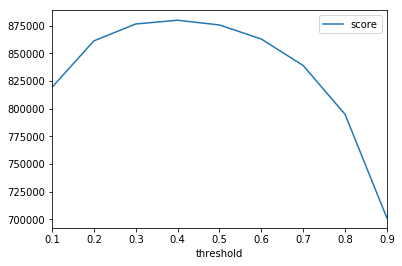

In [62]:
threshold_data.plot(x='threshold', y='score')